# Hierarchical Soccer Model
+ Data Preparation
+ Model 1 - Hierarchical - direct translation from original paper
+ About League Football
+ Forward Model
+ Model 2 - Unpooled Model
+ Why Hierarchical?
+ Model 3 - Revisit original hierarchical model, but with modified prior distributions
+ Model 4 - Non-centred Hierarchical Model
+ Analysis of Model 4 Results
+ Shrinkage
+ Summary
+ Resources
---

In [1]:
import os
import sys
import itertools
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9
from plotnine import *

import pymc as pm
import arviz as az
import pytensor.tensor as pt

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))
from notebooks.scripts.helpers import make_1x2_calib_data, format_season_df, forward_model

In [2]:
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 1925
LOCAL_DATA_DIR = PROJECT_DIR / 'data'
LOCAL_DATA_DIR

PosixPath('/media/david/T7/code/model-bettor/soccer-preds-001/hierarchical-soccer-model/data')

In [3]:
%load_ext watermark
%watermark --iversions

pymc      : 5.7.2
sys       : 3.9.17 | packaged by conda-forge | (main, Aug 10 2023, 07:02:31) 
[GCC 12.3.0]
matplotlib: 3.7.2
arviz     : 0.16.1
pytensor  : 2.14.2
plotnine  : 0.12.2
pandas    : 2.0.3
numpy     : 1.25.2



---
# Data Prep
### Italy Serie A 1992-1993

In [4]:
df_orig1 = pd.read_parquet(LOCAL_DATA_DIR / 'italy_serie-a_1991-1992.parquet')
df_orig1.head()

Wk  Day       Date      Home        Away           Referee  h_ftgoals  \
0   1  Sun 1991-09-01    Napoli    Atalanta   Piero Ceccarini        1.0   
1   1  Sun 1991-09-01  Juventus  Fiorentina  Angelo Amendolia        1.0   
2   1  Sun 1991-09-01     Lazio       Parma   Carlo Sguizzato        1.0   
3   1  Sun 1991-09-01  Cagliari   Sampdoria    Gianni Beschin        3.0   
4   1  Sun 1991-09-01      Bari      Torino   Loris Stafoggia        1.0   

   a_ftgoals  
0        0.0  
1        0.0  
2        1.0  
3        2.0  
4        1.0

### Modify column names to match original paper

In [5]:
df = df_orig1.copy()
df, team_dict = format_season_df(df_orig1)
df.head()

g      home        away  hg  ag  yg1  yg2 result
0  0    Verona        Roma  17  14  0.0  1.0   awin
1  1    Napoli    Atalanta  12   1  1.0  0.0   hwin
2  2     Lazio       Parma  10  13  1.0  1.0   draw
3  3  Juventus  Fiorentina   9   5  1.0  0.0   hwin
4  4     Inter      Foggia   8   6  1.0  1.0   draw

---
# Model 1 - Hierarchical - direct lift from original paper
+ First model as described in the paper - [Bayesian hierarchical model for the prediction of football results - section 2 - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ Code directly translated from original winbugs code to pymc

In [6]:
n_teams = df['hg'].nunique()
home_idx = df['hg'].values
away_idx = df['ag'].values
home_goals = df['yg1'].values
away_goals = df['yg2'].values
print(f'n_teams: {n_teams}')
print(f'home team indices (home_idx): {home_idx[0:5]}...')
print(f'away team indices (away_idx): {away_idx[0:5]}...')
print(f'home goals : {home_goals[0:5]}...')
print(f'away goals: {away_goals[0:5]}...')
tau = 0.0001
sigma = np.sqrt(1.0/tau)
print(f'sigma: {sigma}')

n_teams: 18
home team indices (home_idx): [17 12 10  9  8]...
away team indices (away_idx): [14  1 13  5  6]...
home goals : [0. 1. 1. 1. 1.]...
away goals: [1. 0. 1. 0. 1.]...
sigma: 100.0


In [7]:
with pm.Model() as model1:
    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=0, sigma=sigma)
    tau_att = pm.Gamma('tau_att', 0.01, 0.01)    
    mu_def = pm.Normal('mu_def', mu=0, sigma=sigma)
    tau_def = pm.Gamma('tau_def', 0.01, 0.01)

    # priors
    home = pm.Normal("home", mu=0, sigma=sigma)
    att_t = pm.Normal('att_t', mu=mu_att, tau=tau_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, tau=tau_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

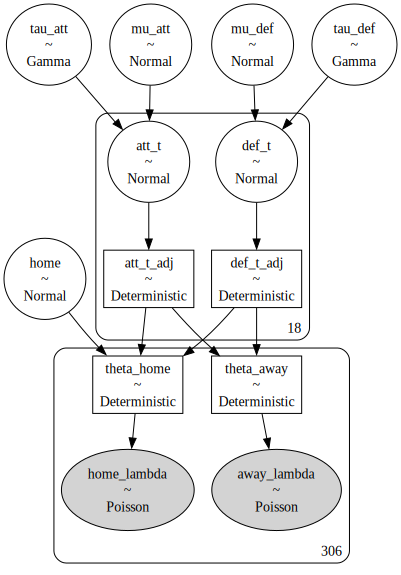

In [8]:
pm.model_to_graphviz(model1)

In [9]:
# # Crashes pymc - ValueError: lam value too large
# with model1:
#     idata1 = pm.sample_prior_predictive()

In [10]:
with model1:
    idata1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, tau_att, mu_def, tau_def, home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1040 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


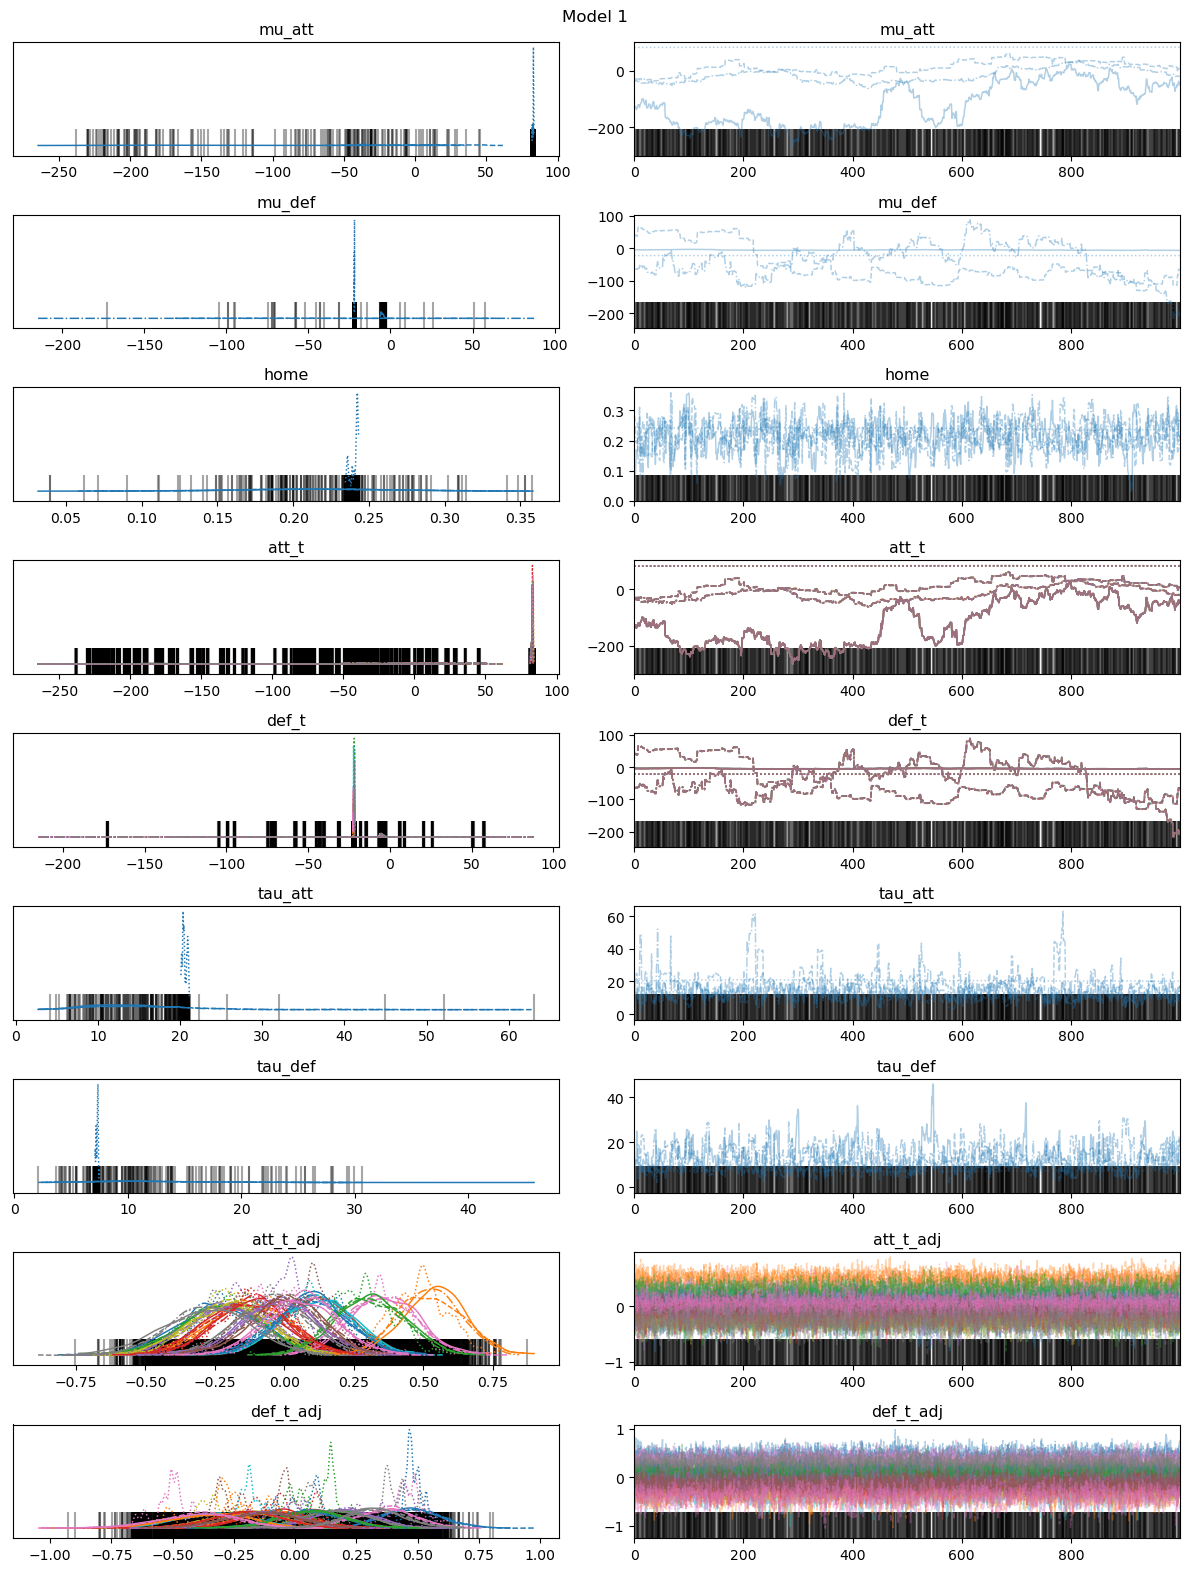

In [11]:
az.plot_trace(idata1, var_names=['^home$', 'att', 'def'], filter_vars='regex', figsize=(12, 16))
plt.suptitle('Model 1')
plt.tight_layout()
plt.show();

## Model 1 Summary
+ Prior predictive sampler will not run due to size of values fed to poisson distribution.
+ Model does not converge.

---

# About League Football
+ In a season - every team plays every other team in the league, once at home and once away.
+ Serie-a 1992-1993 season had 18 teams.
+ This means the 1992-1993 season comprised 18 x 17 = 306 matches.
+ The fixtures are sequenced so that a team mostly alternates between home and away games.
+ Every game can result in one of 3 outcomes - a home win, a draw or an away win.
+ At the end of every season 3 teams are relegated from the league, and 3 new teams are promoted into the league.
+ Games are 2 x 45 minutes, with teams swapping pitch sides at half-time. Additional time may be added to compensate for delays incurred during the first 90 minutes. [Football - wikipedia](https://en.wikipedia.org/wiki/Association_football)
+ Football is a low scoring game, with a reasonably high degree of randomness. The distribution of goals can be modeled by a poisson distribution - See [Predicting Football Results With Statistical Modelling](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)
+ The Poisson Distribution at [distribution zoo](https://ben18785.shinyapps.io/distribution-zoo/)

---
# Forward Model
### Key Inputs
+ If we ignore the hierachical structure we have 3 key inputs
    + home advantage `home` (common across all teams)
    + attack ability `att_t` - The attacking strength of each team
    + defence ability `def_t` - The defending capability of each team
### Zero sum constraint   
+ The attack and defence abilities are adjusted/constrained to sum to zero. This is done by subtracting the mean attack ability (calculated across all teams) from the attack ability of each team. Same for defence.
### Link function and mean score calculation 
+ Every match in the fixture list has a two theta numbers - one for the home team and one for the away team. We can think of these as "expected goals" 
+ These are calculated using the adjusted attack and defence abilities which are fed into 2 equations for every match in the fixture list:
    + theta_home_team = exponential(home advantage + adj_attack[home team] + adj_defence[away_team])
    + theta_away_team = exponential(adj_attack[away_team] + adj_defence[home_team]
### Goal scoring data
+ We now have an "expected goals" number for the home team and the away team for every fixture. This number is modeled as the mean of a poisson distribution, so for each match in the fixture list, we can sample from the two relevant poisson distributions to get a score.

## Simulate a 3 Team League

In [12]:
# Build a 3 team fixture list
teams = [0, 1, 2]
fixtures = np.array(list(zip(*list(itertools.permutations(teams, 2))))).T
df_fixtures = pd.DataFrame(fixtures, columns=['home_team', 'away_team'])
df_fixtures

home_team  away_team
0          0          1
1          0          2
2          1          0
3          1          2
4          2          0
5          2          1

In [13]:
# Equivalent model 1 code ##########
# Atack & Defence priors
# att_t = pm.Normal('att_t', mu=mu_att, tau=tau_att, shape=n_teams)
# def_t = pm.Normal('def_t', mu=mu_def, tau=tau_def, shape=n_teams)

# # Apply zero sum constraint
# att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
# def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))
##################

# Allocate attack and defence abilities to each team
att_t = [1, 2, 3]
def_t = [1, 2, 3]

# Adjust the attack/defence abilities to make them zero sum
att_t_adj = att_t - np.mean(att_t)
def_t_adj = def_t - np.mean(def_t)
#att_t_adj, def_t_adj = apply_zero_sum_constraint(att_t, def_t)
att_t_adj, def_t_adj

(array([-1.,  0.,  1.]), array([-1.,  0.,  1.]))

In [14]:
# For each fixture insert a the home team and away team's adjusted (zero sum) attack and defence values
# Below insert a column of home team attack values
df_fixtures['home_team_att'] = df_fixtures['home_team'].map(lambda x: att_t_adj[x])
df_fixtures

home_team  away_team  home_team_att
0          0          1           -1.0
1          0          2           -1.0
2          1          0            0.0
3          1          2            0.0
4          2          0            1.0
5          2          1            1.0

In [15]:
# For each fixture insert relevant attack and defence values
df_fixtures['home_team_def'] = df_fixtures['home_team'].map(lambda x: def_t_adj[x])
df_fixtures['away_team_att'] = df_fixtures['away_team'].map(lambda x: att_t_adj[x])
df_fixtures['away_team_def'] = df_fixtures['away_team'].map(lambda x: def_t_adj[x])
df_fixtures

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  
0            0.0  
1            1.0  
2           -1.0  
3            1.0  
4           -1.0  
5            0.0

In [16]:
# Equivalent model 1 code ##########
# priors
# home = pm.Normal("home", mu=0, sigma=sigma)
##################

# Set a value for home advantage
home = 1.0
df_fixtures['home'] = home
df_fixtures

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  home  
0            0.0   1.0  
1            1.0   1.0  
2           -1.0   1.0  
3            1.0   1.0  
4           -1.0   1.0  
5            0.0   1.0

In [17]:
# Equivalent model 1 code ##########
# log linear random effect model
# theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
# theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
##################

# Calculate theta - the expected goals for each team for each match
df_fixtures['home_team_raw'] = df_fixtures['home'] + df_fixtures['home_team_att'] + df_fixtures['away_team_def']
df_fixtures['away_team_raw'] = df_fixtures['away_team_att'] + df_fixtures['home_team_def']
df_fixtures['theta_home_team'] = np.exp(df_fixtures['home_team_raw'])
df_fixtures['theta_away_team'] = np.exp(df_fixtures['away_team_raw'])
df_fixtures

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  home  home_team_raw  away_team_raw  theta_home_team  \
0            0.0   1.0            0.0           -1.0         1.000000   
1            1.0   1.0            1.0            0.0         2.718282   
2           -1.0   1.0            0.0           -1.0         1.000000   
3            1.0   1.0            2.0            1.0         7.389056   
4           -1.0   1.0            1.0            0.0         2.718282   
5            0.0   1.0            2.0            1.0         7.389056   

   theta_away_team  
0         0.367879  
1         1.000000  
2         0.367879  
3         2.718282  
4         1.000000  
5         2.718282

In [18]:
# Equivalent model 1 code ##########
# likelihood
# home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
# away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)
##################

# For each team in each match draw a sample from a poisson distribution
# Every match has 2 poisson distributions associated with it - one for the home team, and one for the away team
df_fixtures['home_team_goals'] = np.random.poisson(lam=df_fixtures['theta_home_team'])
df_fixtures['away_team_goals'] = np.random.poisson(lam=df_fixtures['theta_away_team'])
df_fixtures

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  home  home_team_raw  away_team_raw  theta_home_team  \
0            0.0   1.0            0.0           -1.0         1.000000   
1            1.0   1.0            1.0            0.0         2.718282   
2           -1.0   1.0            0.0           -1.0         1.000000   
3            1.0   1.0            2.0            1.0         7.389056   
4           -1.0   1.0            1.0            0.0         2.718282   
5            0.0   1.0            2.0            1.0         7.389056   

   theta_away_team  home_team_goals  away_team_goals  
0         0.367879                0                0  
1         1.000000                0                1  
2         0.367879                0                0  
3         2.718282                7                1  
4         1.000000                3                0  
5         2.718282                9                0

## Simulate 18 team leagues with various starting values

In [19]:
n_teams = 18
att_t = np.random.uniform(0, 20, size=n_teams)
def_t = np.random.uniform(0, 20, size=n_teams)
home = 10
season_sim = forward_model(home, att_t, def_t, n_teams)
season_sim

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0            0          1      -4.971052       7.949479       5.189043   
1            0          2      -4.971052       7.949479     -11.785299   
2            0          3      -4.971052       7.949479       2.728292   
3            0          4      -4.971052       7.949479       6.812633   
4            0          5      -4.971052       7.949479      -9.557328   
..         ...        ...            ...            ...            ...   
301         17         12       5.819115       2.089032       7.071042   
302         17         13       5.819115       2.089032      -2.204369   
303         17         14       5.819115       2.089032      -0.946538   
304         17         15       5.819115       2.089032       5.065334   
305         17         16       5.819115       2.089032      -9.368788   

     away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0        11.485478      16.514426      13.138523     1.486360e+07   
1        -6.396982      -1.368035      -3.835819     2.546069e-01   
2        -3.556341       1.472606      10.677771     4.360586e+00   
3        -1.776937       3.252011      14.762113     2.584225e+01   
4        -0.986375       4.042572      -1.607849     5.697272e+01   
..             ...            ...            ...              ...   
301       5.857064      21.676179       9.160074     2.593253e+09   
302       0.410603      16.229718      -0.115337     1.118090e+07   
303      -5.088005      10.731110       1.142494     4.575748e+04   
304      -4.300521      11.518594       7.154365     1.005685e+05   
305      -0.087354      15.731761      -7.279756     6.795433e+06   

     theta_away_team  home_team_goals  away_team_goals  
0       5.081453e+05         14860793           508174  
1       2.158365e-02                1                0  
2       4.338076e+04                3            43517  
3       2.576939e+06               28          2577578  
4       2.003181e-01               63                2  
..               ...              ...              ...  
301     9.509756e+03       2593295510             9500  
302     8.910657e-01         11180366                4  
303     3.134576e+00            45404                3  
304     1.279680e+03           100530             1238  
305     6.893538e-04          6796444                0  

[306 rows x 12 columns]

In [20]:
n_teams = 18
att_t = np.random.uniform(0, 3, size=n_teams)
def_t = np.random.uniform(-3, 0, size=n_teams)
home = 0.5
season_sim = forward_model(home, att_t, def_t, n_teams).reset_index().rename(columns={'index': 'game_num'})
season_sim

game_num  home_team  away_team  home_team_att  home_team_def  \
0           0          0          1       0.994197       0.231225   
1           1          0          2       0.994197       0.231225   
2           2          0          3       0.994197       0.231225   
3           3          0          4       0.994197       0.231225   
4           4          0          5       0.994197       0.231225   
..        ...        ...        ...            ...            ...   
301       301         17         12       1.107378      -0.670442   
302       302         17         13       1.107378      -0.670442   
303       303         17         14       1.107378      -0.670442   
304       304         17         15       1.107378      -0.670442   
305       305         17         16       1.107378      -0.670442   

     away_team_att  away_team_def  home_team_raw  away_team_raw  \
0        -1.165484       0.452718       1.946915      -0.934259   
1         1.015027       0.321240       1.815437       1.246252   
2         0.398527       0.057237       1.551434       0.629752   
3         0.363365      -0.299664       1.194533       0.594589   
4        -1.616918       0.773551       2.267748      -1.385693   
..             ...            ...            ...            ...   
301       0.476107      -0.195802       1.411575      -0.194335   
302      -0.307866      -0.623475       0.983903      -0.978308   
303      -1.530623       0.756561       2.363939      -2.201065   
304       0.664256       0.276067       1.883445      -0.006186   
305       0.348858       0.666779       2.274157      -0.321584   

     theta_home_team  theta_away_team  home_team_goals  away_team_goals  
0           7.007041         0.392877                9                0  
1           6.143762         3.477286                8                5  
2           4.718233         1.877145                6                5  
3           3.302016         1.812287                3                2  
4           9.657629         0.250150                9                0  
..               ...              ...              ...              ...  
301         4.102414         0.823382                2                0  
302         2.674875         0.375947                1                0  
303        10.632752         0.110685                6                1  
304         6.576121         0.993833                3                1  
305         9.719722         0.725000               10                1  

[306 rows x 13 columns]

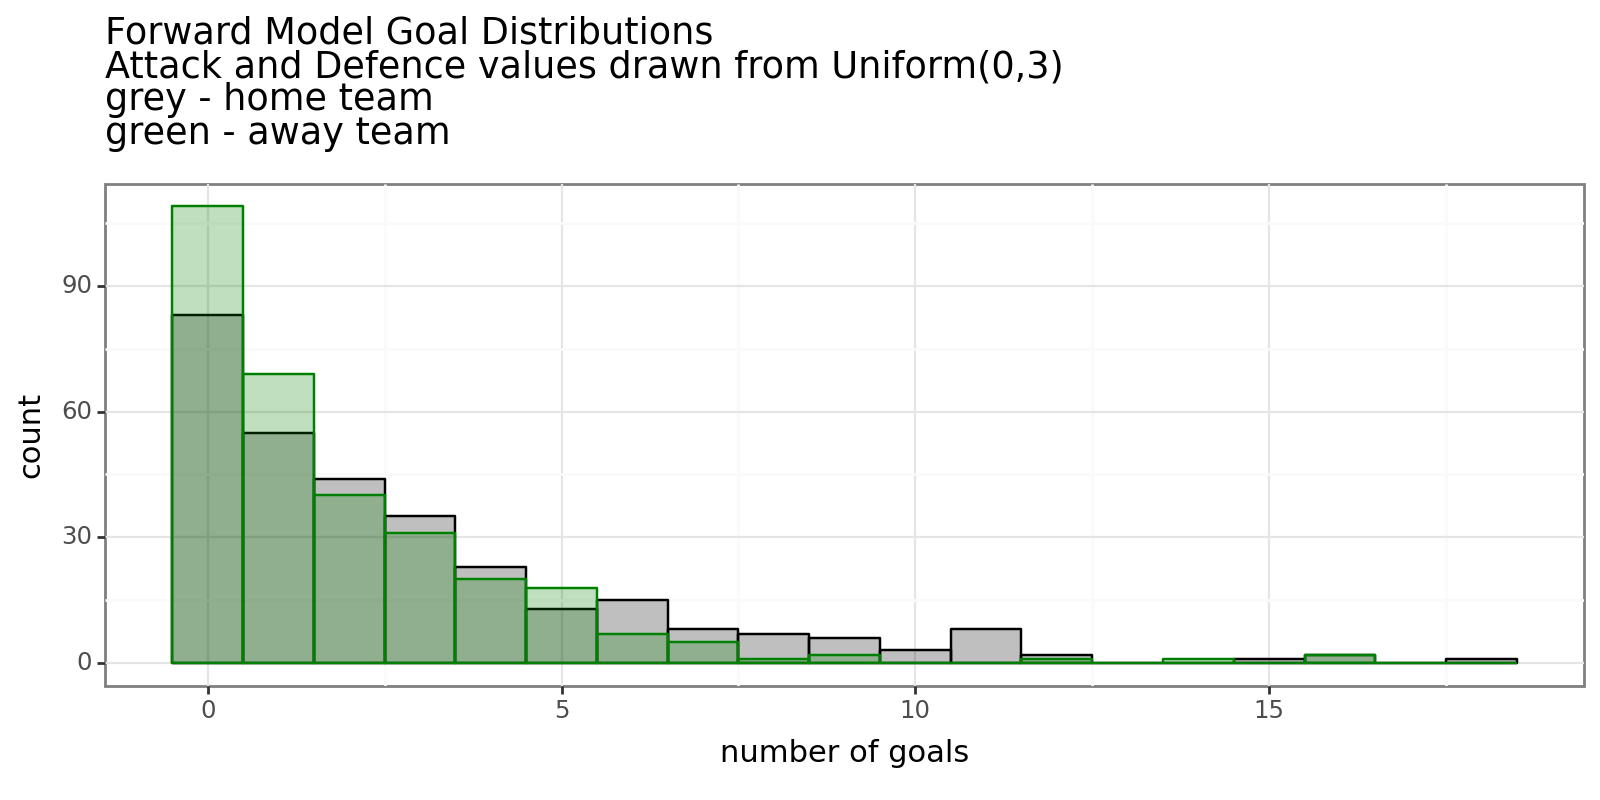

In [21]:
p = (ggplot(season_sim, aes('home_team_goals')) +
     geom_histogram(fill='black', color='black', binwidth=1, alpha=0.25) +
     geom_histogram(aes('away_team_goals'), fill='green', color='green', binwidth=1, alpha=0.25)+
     labs(x='number of goals',
          y='count',
          title=f'Forward Model Goal Distributions\nAttack and Defence values drawn from Uniform(0,3)\ngrey - home team\ngreen - away team') +
     theme(figure_size=(8,4))
    )
plt.close()
p.draw()

## Forward Model Summary
+ The attack and defence prior values seem excessively large in the previous model
+ We have established some approximate bounds on the priors that:
    + Are large enough to allow the model to learn from the data.
    + Are not so large that the sampler breaks.

---
# Model 2 - Unpooled Model
+ Prior values adjusted to smaller based on simulation
+ Unpooled, non-hierarchical model
+ Variable names changed for readability

In [22]:
with pm.Model() as model2:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)

    # priors
    att_t = pm.Normal('att_t', mu=1.5, sigma=0.66, shape=n_teams)
    def_t = pm.Normal('def_t', mu=-1.5, sigma=0.66, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_goalsl = pm.Poisson('home_goalsl', mu=theta_home, observed=home_goals)
    away_goalsl = pm.Poisson('away_goalsl', mu=theta_away, observed=away_goals)

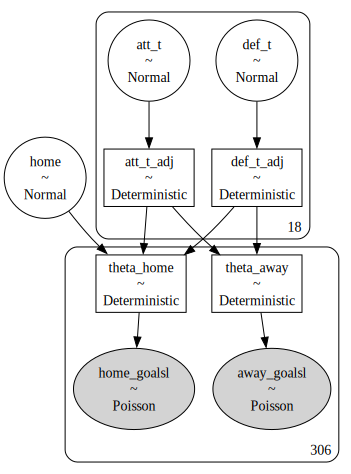

In [23]:
pm.model_to_graphviz(model2)

## Model 2 Prior Predictive Checks

In [24]:
with model2:
    idata2 = pm.sample_prior_predictive()

Sampling: [att_t, away_goalsl, def_t, home, home_goalsl]


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


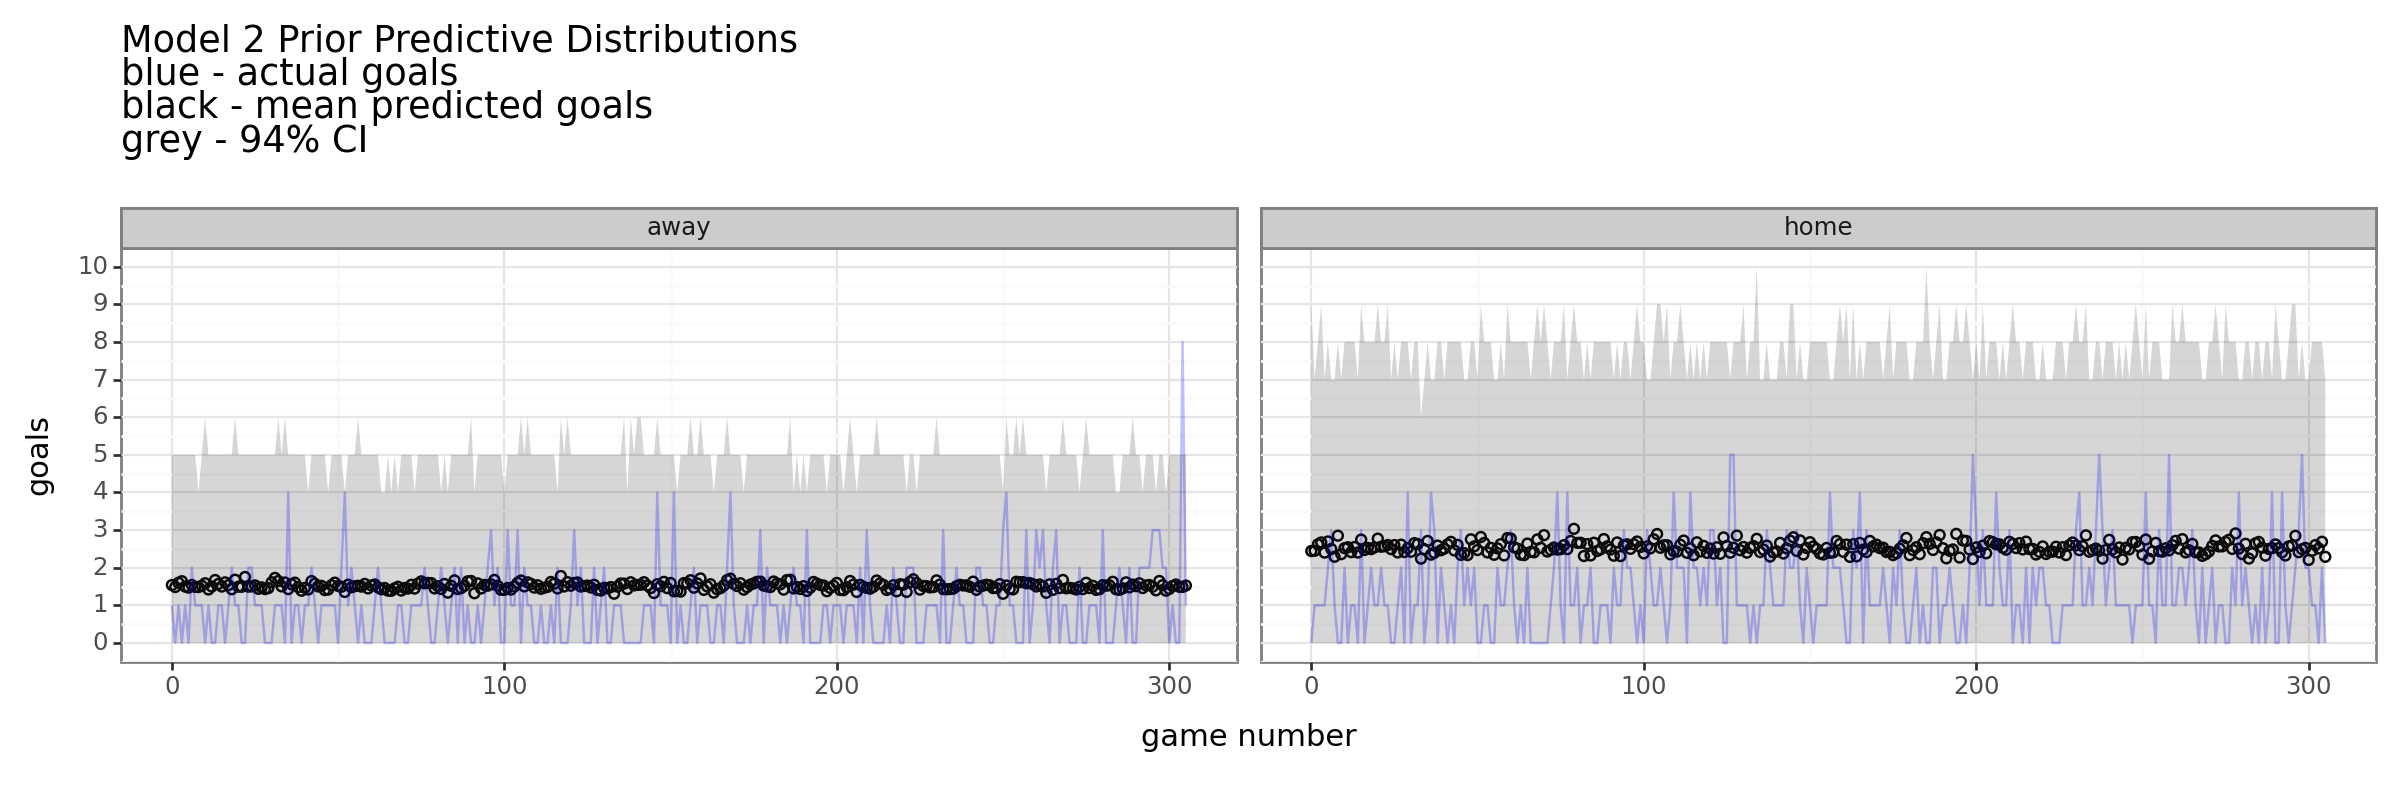

In [25]:
summ_prior2 = az.summary(idata2.prior_predictive)
summ_prior2['locn'] = summ_prior2.index.str.split('_').str[0]
summ_prior2['game_num'] = summ_prior2.index.str.split('[').str[1].str.replace(']', '').astype(int)
summ_prior2['obs_goals'] = np.hstack([df['yg1'].values, df['yg2'].values])

p = (ggplot(summ_prior2, aes(x='game_num', group='locn')) +
     geom_point(aes(y='mean'), fill='none') +
     geom_ribbon(aes(ymin='hdi_3%', ymax='hdi_97%'), alpha=0.2) +
     geom_line(aes(y='obs_goals'), color='blue', alpha=0.25) +
     scale_y_continuous(breaks=np.arange(14)) +
     labs(x='game number',
          y='goals',
          title=f'Model 2 Prior Predictive Distributions\nblue - actual goals\nblack - mean predicted goals\ngrey - 94% CI') +
     facet_wrap('locn', as_table=False) +
     theme(figure_size=(12,4))
    )
plt.close()
p.draw()

## Model 2 Posterior

In [26]:
with model2:
    idata2.extend(pm.sample(idata_kwargs = {'log_likelihood': True}))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


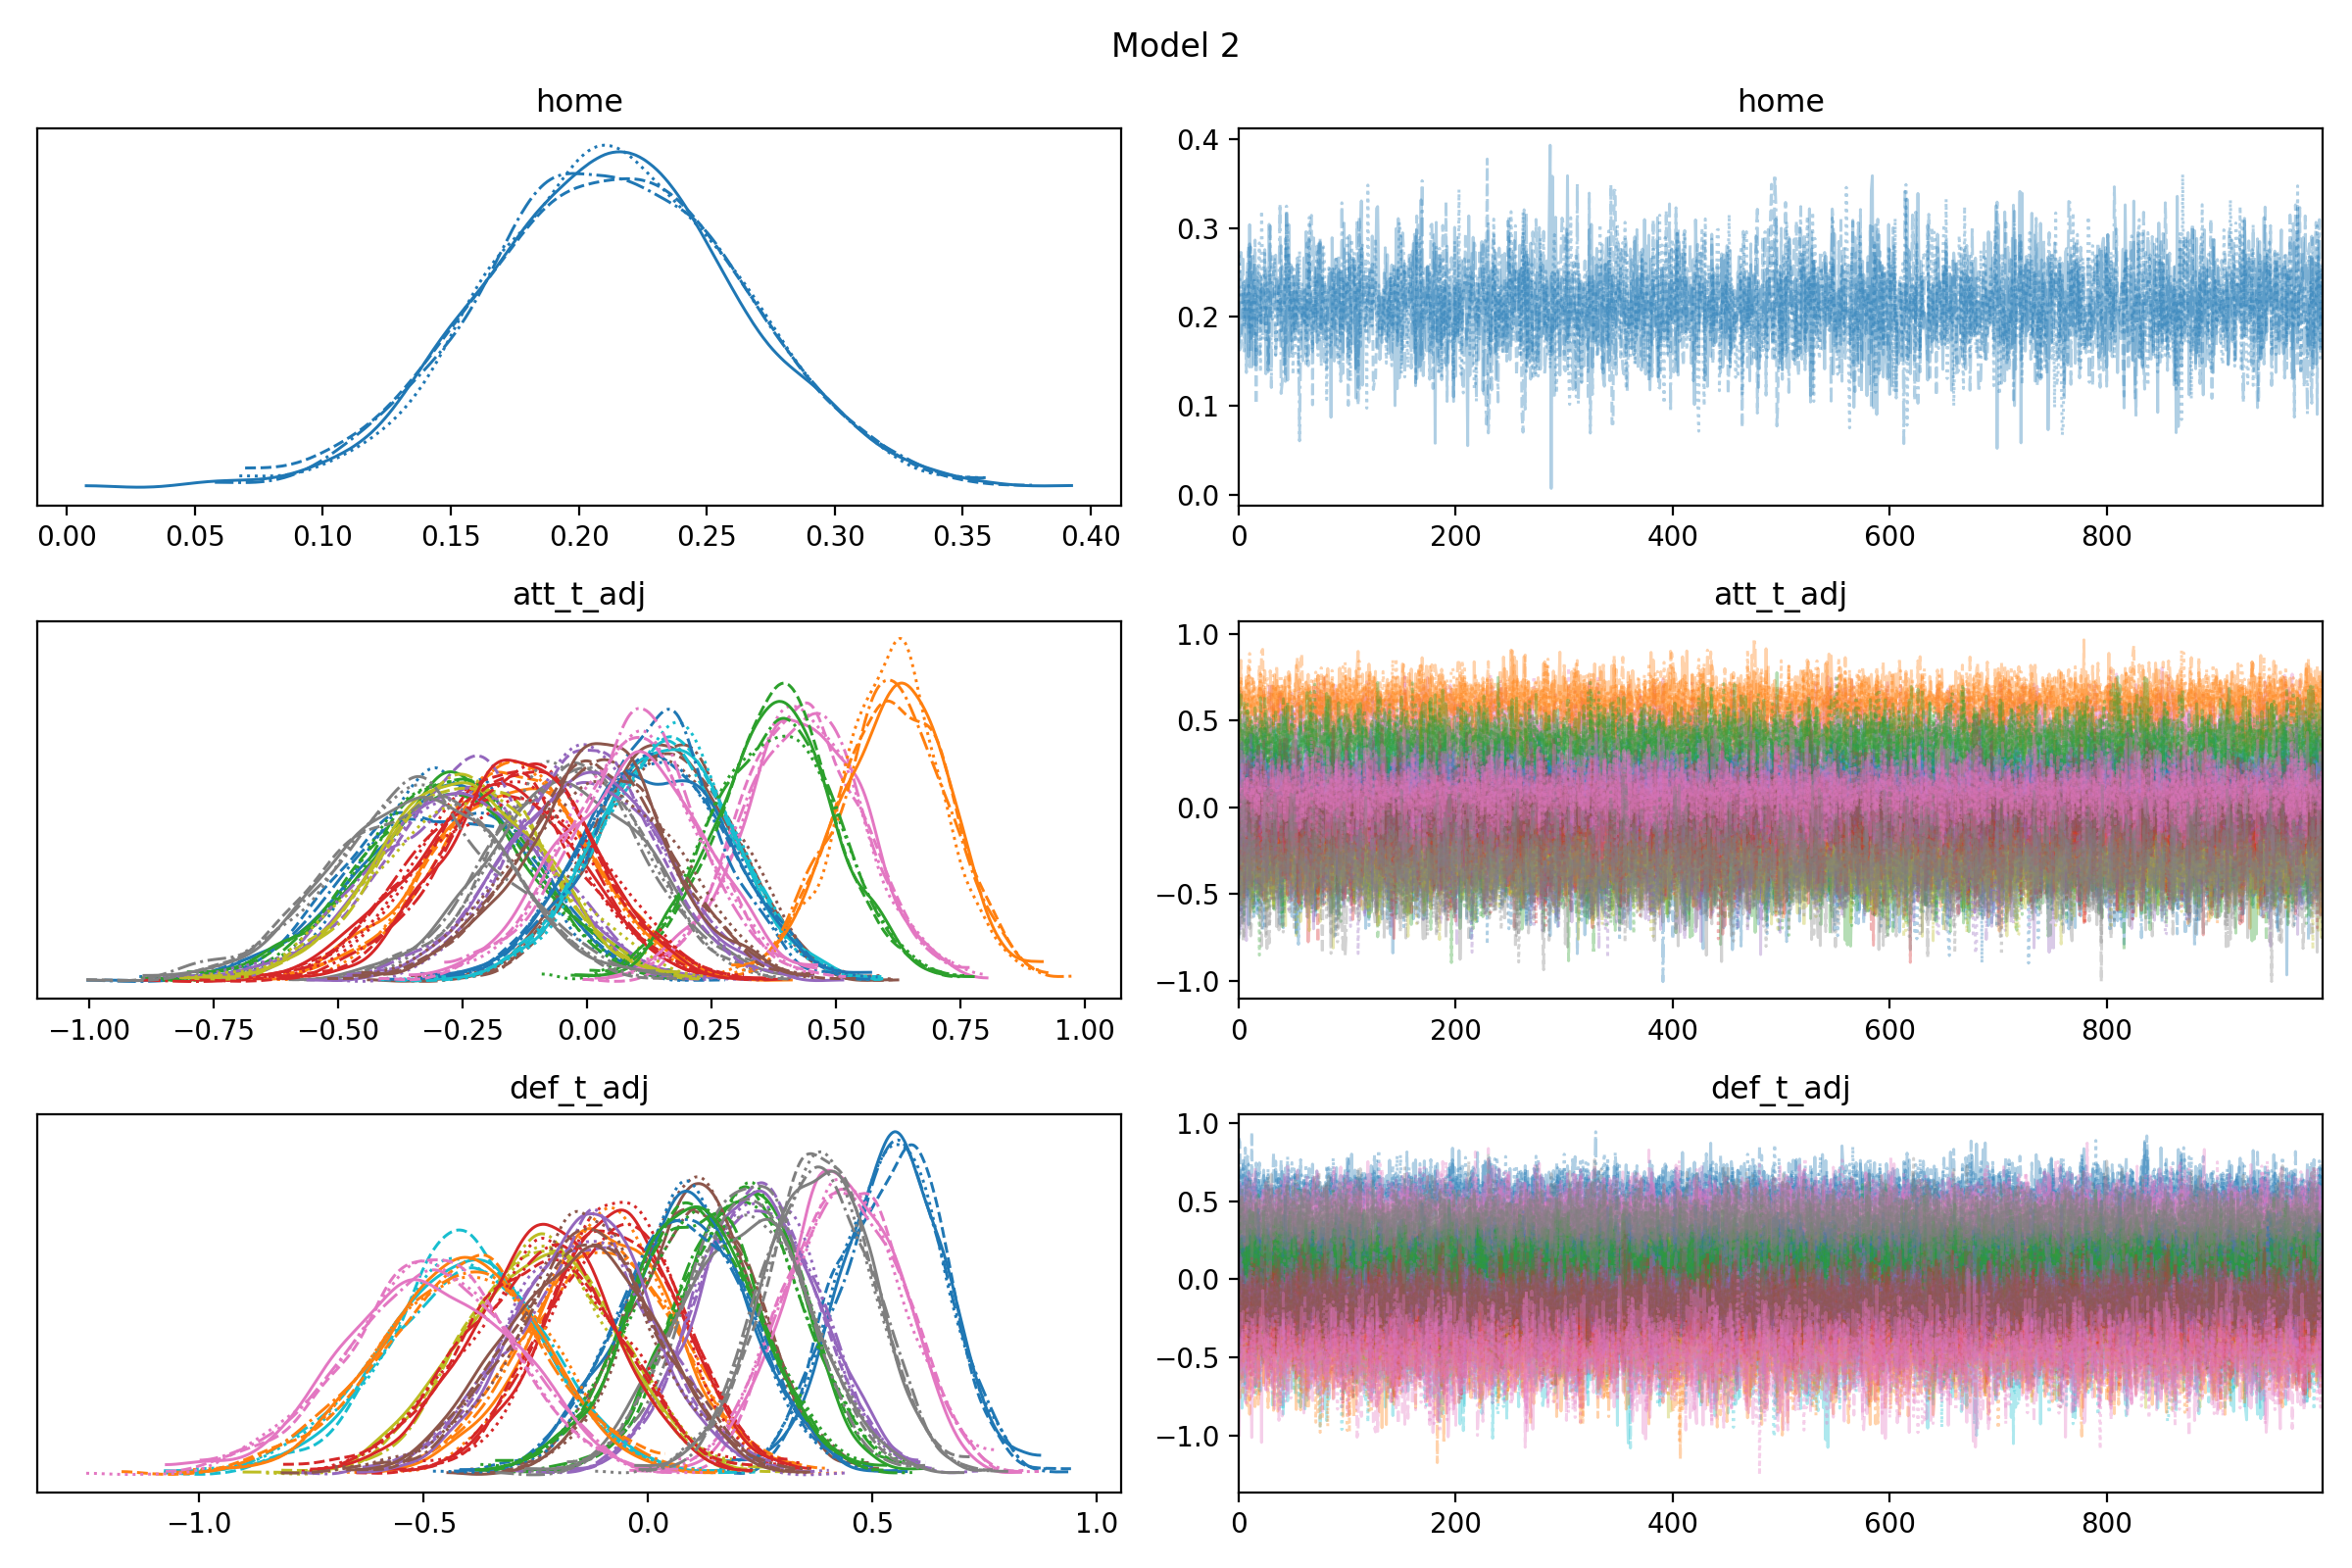

In [27]:
az.plot_trace(idata2, var_names=['^home$', 't_adj'], filter_vars='regex', figsize=(12, 8))
plt.suptitle('Model 2')
plt.tight_layout()
plt.show();

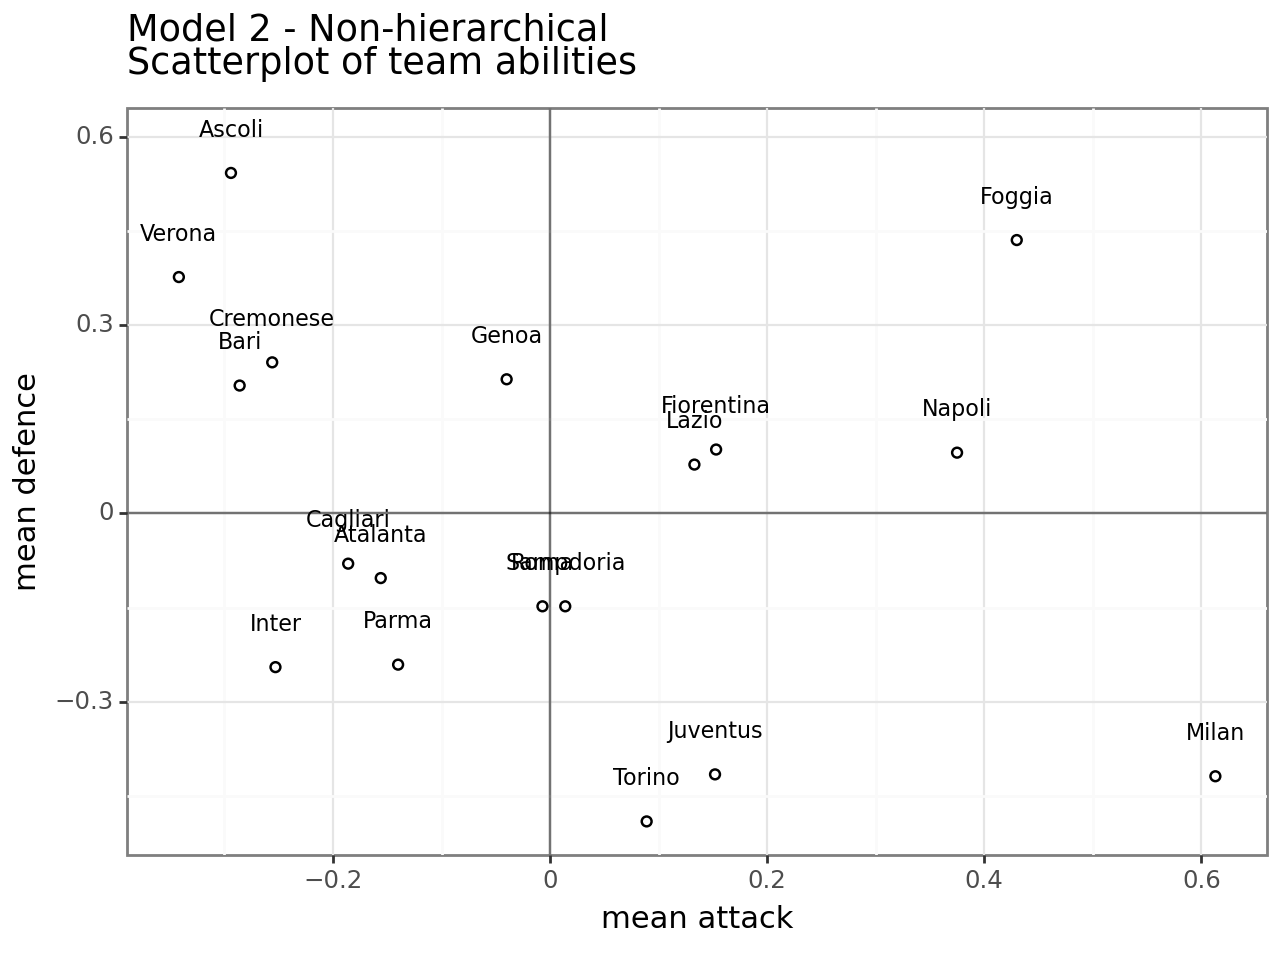

In [28]:
summ2 = az.summary(idata2)

att_effect = summ2.filter(regex='att_t_adj', axis=0)['mean'].rename('mean_attack_effect').reset_index(drop=True)
def_effect = summ2.filter(regex='def_t_adj', axis=0)['mean'].rename('mean_defence_effect').reset_index(drop=True)
non_hier_effects = pd.concat([att_effect, def_effect], axis=1)
non_hier_effects.index = list(team_dict.keys())
non_hier_effects['model'] = 'non-hier'

p = (ggplot(non_hier_effects, aes(x='mean_attack_effect', y='mean_defence_effect')) +
     geom_point(fill='none', color='black') +
     geom_text(aes(label=non_hier_effects.index), color='black', size=8, nudge_y=0.05, va='bottom') +
     geom_hline(yintercept=0.0, alpha=0.5) +
     geom_vline(xintercept=0.0, alpha=0.5) +
     labs(title='Model 2 - Non-hierarchical\nScatterplot of team abilities',
          x='mean attack', y='mean defence')
     )
p.draw()

## Model 2 Posterior Predictive

In [29]:
with model2:
    pm.sample_posterior_predictive(trace=idata2, extend_inferencedata=True)

Sampling: [away_goalsl, home_goalsl]


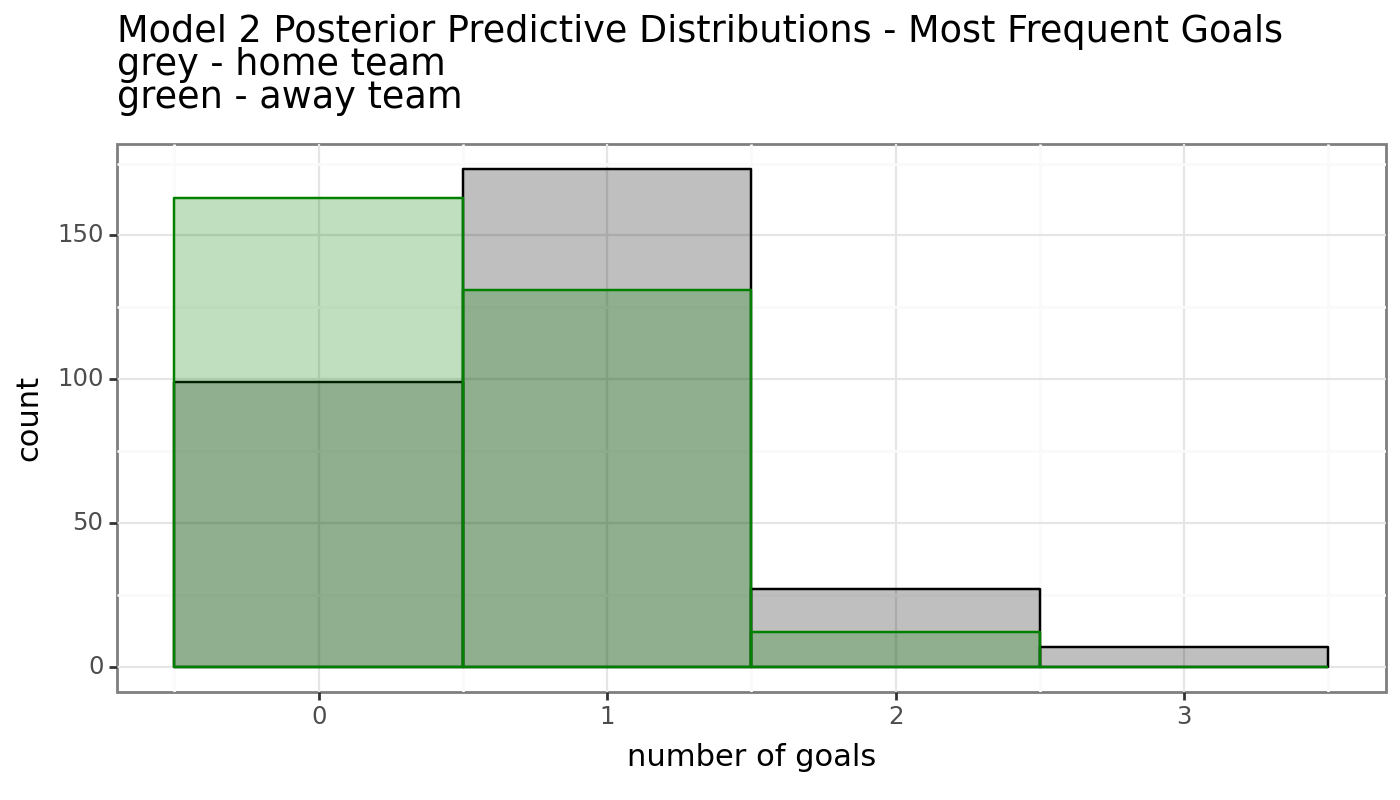

In [30]:
# Get the modes from the first chain of the posterior predictive distributions
home_goals_mode = idata2.posterior_predictive['home_goalsl'][0].to_dataframe().groupby(by='home_goalsl_dim_2')['home_goalsl'].agg(lambda x: x.value_counts().index[0])
away_goals_mode = idata2.posterior_predictive['away_goalsl'][0].to_dataframe().groupby(by='away_goalsl_dim_2')['away_goalsl'].agg(lambda x: x.value_counts().index[0])
postpred_df = pd.concat([home_goals_mode, away_goals_mode], axis=1)

p = (ggplot(postpred_df, aes('home_goalsl')) +
     geom_histogram(fill='black', color='black', binwidth=1, alpha=0.25) +
     geom_histogram(aes('away_goalsl'), fill='green', color='green', binwidth=1, alpha=0.25)+
     labs(x='number of goals',
          y='count',
          title=f'Model 2 Posterior Predictive Distributions - Most Frequent Goals\ngrey - home team\ngreen - away team') +
     theme(figure_size=(7,4))
    )
plt.close()
p.draw()

## Model 2 Summary
+ Prior Predictive checks look good
+ Model converges
+ Posterior Predictive mode of goals distributions agree with intuition

---
# Hierarchical Models
## Why Hierarchical ?
+ Hierarchical data
+ Pooled Model - Useless
+ Unpooled - Model 2
+ Hierarchical - somewhere between fully pooled and unpooled
+ Hierarchical solves
    + Promotion/relegation problem
    + Strength of schedule problem
    + Author's use is related to correlation between home and away scores. The hierarchical model takes into account the relationship between parameters, so there is no need for a more complex distribution such as a bivariate poisson, or a correction factor.

## What is a hierarchical Model?
+ Instead of 18 prior distributions - one per team, we specify a hyperprior which is used to specify the prior distributions.
---

# Model 3 Revisit original hierarchical model, but with modified prior distributions
+ Hierarchical Model
+ Priors narrowed based on learning from non-hierarchical model
+ Prior distributions changed to more common distributions
+ Vraiable names changed for readability

In [31]:
with pm.Model() as model3:
    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=2.0, sigma=1.0)
    sigma_att = pm.HalfNormal('sigma_att', sigma=1.0)    
    mu_def = pm.Normal('mu_def', mu=-2.0, sigma=1.0)
    sigma_def = pm.HalfNormal('sigma_def', sigma=1.0)

    # priors
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)
    att_t = pm.Normal('att_t', mu=mu_att, sigma=sigma_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, sigma=sigma_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_goalsl = pm.Poisson('home_goalsl', mu=theta_home, observed=home_goals)
    away_goalsl = pm.Poisson('away_goalsl', mu=theta_away, observed=away_goals)

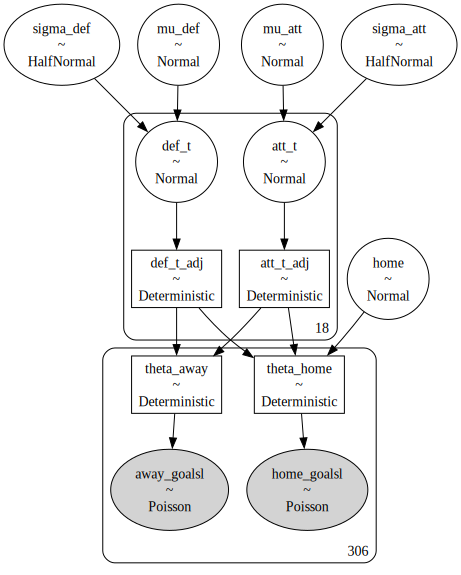

In [32]:
pm.model_to_graphviz(model3)

In [33]:
with model3:
    idata3 = pm.sample_prior_predictive()

Sampling: [att_t, away_goalsl, def_t, home, home_goalsl, mu_att, mu_def, sigma_att, sigma_def]


In [34]:
with model3:
    idata3.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, sigma_att, mu_def, sigma_def, home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


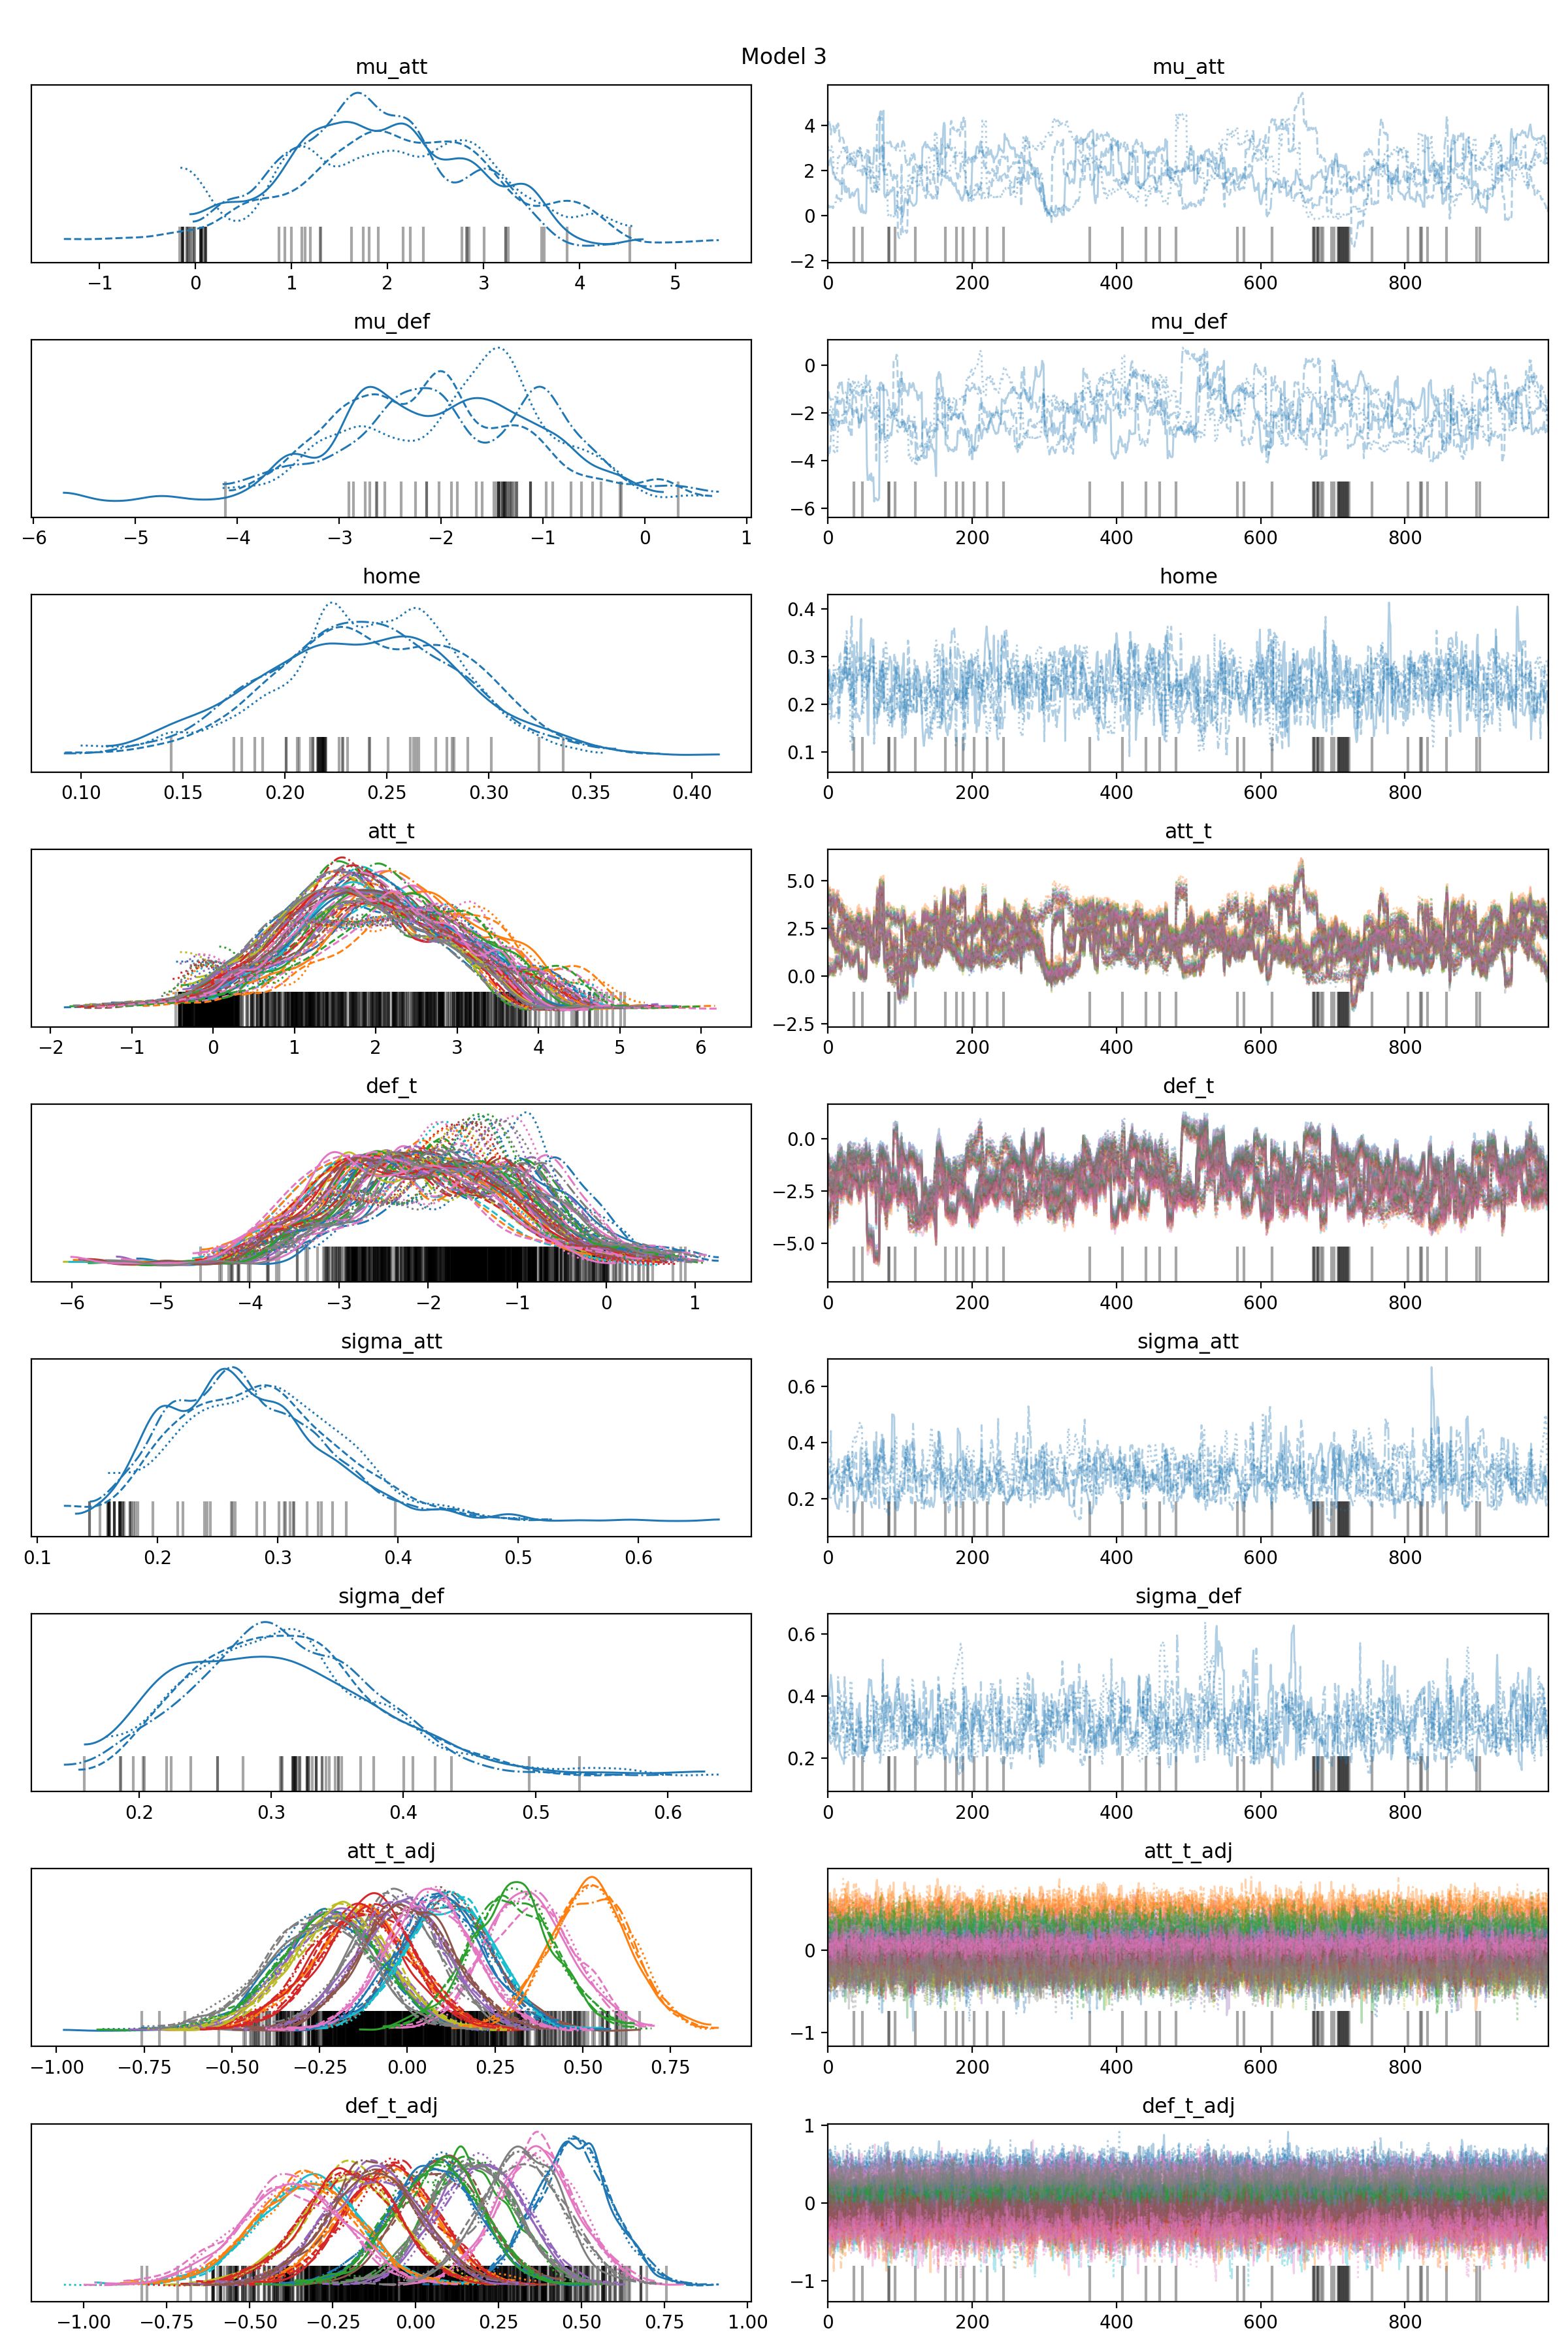

In [35]:
az.plot_trace(idata3, var_names=['^home$', 'att', 'def'], filter_vars='regex', figsize=(12, 18))
plt.suptitle('Model 3')
plt.tight_layout()
plt.show();

## Model 3 Diagnosis
+ Google search
    + get more data - no go
    + reparametrize to a non-centred model - Why?
        + sampler takes a fixed step size
        + with hierarchical models and weak data the posterior geometry can be "sharp" ie have relatively high gradients
        + the sampler cannot sample proportionally from these areas, so we may end up with a biased model
        + the sampler recognizes these problem steps and reports them as divergences
        + [Explained in Statistical Rethinking 2023 lecture 14 at 44:06](https://www.youtube.com/watch?v=Es44-Bp1aKo&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus&index=14)
        + [Alternative explanation - Centered versus non-centred hierarchical models (YouTube Video) - Ben Lambert](https://www.youtube.com/watch?v=gSd1msFFZTw)
     
## Centered to Non-Centered parameterization
### Before
+ $mu_{att} \sim Normal(\mu=2.0, \sigma=1.0)$
+ $sigma_{att} \sim HalfNormal(\sigma=1.0)$
+ $att_t \sim Normal(\mu=mu_{att},\; \sigma=sigma_{att})$

### After
+ $mu_{att} \sim Normal(\mu=2.0, \sigma=1.0)$
+ $sigma_{att} \sim HalfNormal(\sigma=1.0)$
+ $Z \sim Normal(0,1)$
+ $att_t = mu_{att} + Z \times sigma_{att}$

---
# Model 4 - Non-centred Hierarchical Model
+ Model 3 modified to a non-centred parametrization

In [36]:
with pm.Model() as model4:
    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=2.0, sigma=1.0)
    sigma_att = pm.HalfNormal('sigma_att', sigma=1.0)    
    mu_def = pm.Normal('mu_def', mu=-2.0, sigma=1.0)
    sigma_def = pm.HalfNormal('sigma_def', sigma=1.0)

    # New - offsets ?
    att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
    def_t_ = pm.Normal('def_t_', 0, 1, shape=n_teams)

    # priors
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)
    # previous priors
    # att_t = pm.Normal('att_t', mu=mu_att, sigma=sigma_att, shape=n_teams)
    # def_t = pm.Normal('def_t', mu=mu_def, sigma=sigma_def, shape=n_teams)
    # Changed priors    
    att_t = pm.Deterministic('att_t', mu_att + att_t_ * sigma_att)
    def_t = pm.Deterministic('def_t', mu_def + def_t_ * sigma_def)
    
    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_goalsl = pm.Poisson('home_goalsl', mu=theta_home, observed=home_goals)
    away_goalsl = pm.Poisson('away_goalsl', mu=theta_away, observed=away_goals)

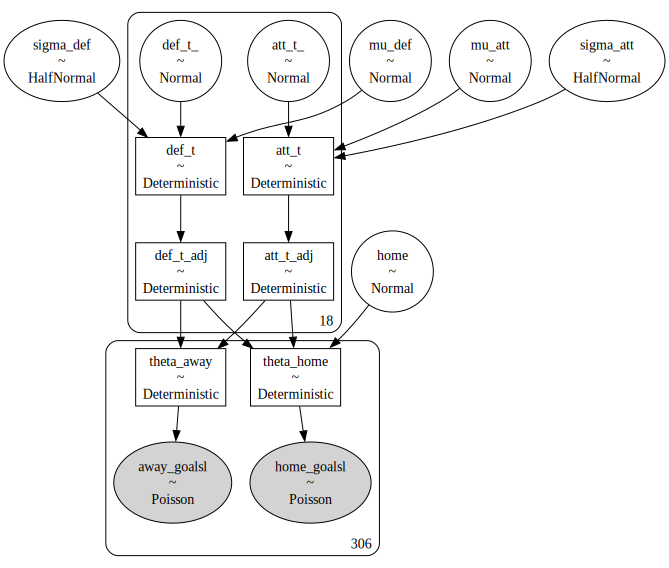

In [37]:
pm.model_to_graphviz(model4)

In [ ]:
with model4:
    idata4 = pm.sample_prior_predictive()
    idata4.extend(pm.sample(idata_kwargs = {'log_likelihood': True}))
    pm.sample_posterior_predictive(trace=idata4, extend_inferencedata=True)

Sampling: [att_t_, away_goalsl, def_t_, home, home_goalsl, mu_att, mu_def, sigma_att, sigma_def]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_, home]


In [ ]:
az.plot_trace(idata4, var_names=['^home$', 'att', 'def'], filter_vars='regex', figsize=(12, 18))
plt.suptitle('Model 4')
plt.tight_layout()
plt.show();

---
# Analysis of Model 4 Results
## Comparison to Table 2 in original paper
+ [Bayesian hierarchical model for the prediction of football results](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)

In [ ]:
summ4 = az.summary(idata4, hdi_prob=0.95).round(2)
# Compare to Table 2 in https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf
att_rows = summ4.filter(regex='att_t_adj', axis=0).index.tolist()
atts = summ4.loc[att_rows + ['home'], ['mean', 'hdi_2.5%', 'hdi_97.5%']]
atts.index = list(team_dict.keys()) + ['home']
atts

## Reliability Plots

In [ ]:
home_goals_df = idata4.posterior_predictive['home_goalsl'].to_dataframe()
away_goals_df = idata4.posterior_predictive['away_goalsl'].to_dataframe()
scores_df = pd.concat([home_goals_df, away_goals_df], axis=1).droplevel((0,1), axis=0).reset_index().rename(columns={'index': 'game_num'})

game_probs = []
for game_num, game_df in scores_df.groupby(by=['game_num']):
    p_hwin = (game_df['home_goalsl'] > game_df['away_goalsl']).sum() / len(game_df)
    p_draw = (game_df['home_goalsl'] == game_df['away_goalsl']).sum() / len(game_df)
    p_awin = (game_df['home_goalsl'] < game_df['away_goalsl']).sum() / len(game_df)
    game_probs.append(pd.DataFrame({'p(hwin)pred': [p_hwin], 'p(draw)pred': [p_draw], 'p(awin)pred': [p_awin]}, index=game_num))
probs_df = pd.concat(game_probs, axis=0)
df_res = pd.concat([df, probs_df, pd.get_dummies(df['result']).astype(int)], axis=1)
df_res.head()

In [ ]:
df_res[['p(hwin)pred', 'p(draw)pred', 'p(awin)pred']].mean()

In [ ]:
dfc = df_res.copy()
n_bins = 5
strategy='quantile'
pred_cols=['p(hwin)pred', 'p(draw)pred', 'p(awin)pred']
n_matches = len(dfc)
cal_df = make_1x2_calib_data(dfc, n_bins=n_bins, strategy=strategy, pred_cols=pred_cols)

p = (ggplot(cal_df, aes(x='mean_predicted_proba', y='mean_actual_proba', group='calib')) +
     geom_point(fill='none') +
     geom_abline(intercept=0, slope=1, alpha=0.5, linetype='dashed') +
     coord_cartesian(xlim=(0, 1.0), ylim=(0, 1.0)) +
     labs(x='mean predicted probability',
          y='mean actual probability',
          title=f'Model 4 Reliability Plots\n{n_matches} matches - {n_bins} {strategy} bins') +
     facet_wrap('calib') +
     theme(figure_size=(9,4))
    )
plt.close()
p.draw()

## LOO Metric - Non-Hierarchical vs Hierarchical Model

In [ ]:
comp_df = az.compare({'non-hier': idata2, 'hier': idata4}, var_name='home_goalsl')
az.plot_compare(comp_df, figsize=(8,3))
plt.suptitle('Home Goals', fontsize=16)
plt.tight_layout()
plt.show();

In [ ]:
comp_df = az.compare({'non-hier': idata2, 'hier': idata4}, var_name='away_goalsl')
az.plot_compare(comp_df, figsize=(8,3))
plt.suptitle('Away Goals', fontsize=16)
plt.tight_layout()
plt.show();

## Summary - Model 4 Results Analysis
+ Good agreement to results shown in the original paper.
+ Calibration Plots show linear relationship between predicted probabilities and actual probabilities.
+ Hierarchical model may be slightly better than non-hierarchical model based on goals scored by each team.
+ With two likelihoods we may need to think about how to judge the model - goals, goal difference, probabilities, scores ?
---

# Shrinkage

In [ ]:
att_effect = summ4.filter(regex='att_t_adj', axis=0)['mean'].rename('mean_attack_effect').reset_index(drop=True)
def_effect = summ4.filter(regex='def_t_adj', axis=0)['mean'].rename('mean_defence_effect').reset_index(drop=True)
hier_effects = pd.concat([att_effect, def_effect], axis=1)
hier_effects.index = list(team_dict.keys())
hier_effects['model'] = 'hier'
full_effects = pd.concat([non_hier_effects, hier_effects], axis=0)

p = (ggplot(full_effects, aes(x='mean_attack_effect', y='mean_defence_effect', color='model')) +
     geom_point(fill='none') +
     geom_text(non_hier_effects, aes(label=non_hier_effects.index), color='black', size=8, nudge_y=0.05, va='bottom') +
     geom_hline(yintercept=0.0, alpha=0.25) +
     geom_vline(xintercept=0.0, alpha=0.25) +
     labs(title='Hierarchical vs Non-Hierarchical Model Results\nScatterplot of team strengths',
          x='mean attack', y='mean defence')
     )
p.draw()

---
# Summary
+ Hierarchical Models can overcome some challenges such as unbalanced data, no data
+ The structure allows categories to relate to each other - makes full use of all the data
+ Hierarchical models are more skeptical about extreme data. They tend to pull extreme data back to the mean - shrinkage. This can lead to better generalization on out of sample predictions.
+ The hierarchical structure can be a challenge for the sampler, especially with lower data volume and weak data. We can overcome this with either more data, or re-parameterizing the model to better suit the sampler.
+ The particular reparameterization depends on the modeled distributions

---
# Resources
## Football Models
+ [Predicting Football Results With Statistical Modelling (webpage) - David Sheehan](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)
+ [Bayesian hierarchical model for the prediction of football results (pdf) - Baio, Gianluca & Blangiardo, Marta. (2010). Journal of Applied Statistics. 37. 253-264. 10.1080/02664760802684177. ](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ [Analysis of sports data by using bivariate
Poisson models (pdf) - Dimitris Karlis & Ioannis Ntzoufras](http://www2.stat-athens.aueb.gr/~jbn/papers2/08_Karlis_Ntzoufras_2003_RSSD.pdf)
+ [Hierarchical Modelling in Stan: Predicting the Premier League (YouTube video & associated material) -  Maggie Lieu - Stan Youtube channel](https://www.youtube.com/watch?v=dNZQrcAjgXQ&list=PLdw9iy95A5dh9tr3ZEiPICRYu8geqi9N9&index=103)
## Hierarchical Models
+ [Why hierarchical models are awesome, tricky, and Bayesian (webpage) - Thomas Wiecki - twiecki.io website](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)
+ [Diagnosing Biased Inference with Divergences (webpage) - pymc documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)
+ [Funneling (webpage) - Samuel Robert Mathias - the cracked bassoon website](https://crackedbassoon.com/writing/funneling)
+ [Centered versus non-centred hierarchical models (YouTube Video) - Ben Lambert](https://www.youtube.com/watch?v=gSd1msFFZTw)
+ [Statistical Rethinking 2023 -14 - Bonus section - (YouTube Video) - Richard McElreath](https://www.youtube.com/watch?v=Es44-Bp1aKo&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus&index=15)
+ [Stan User's Guide section 25.7 Reparameterization (online book) - Stan Development Team](https://mc-stan.org/docs/stan-users-guide/reparameterization.html)
## Other
+ [Bayesian Modeling and Computation in Python (online book) - Martin Osvaldo A, Kumar Ravin; Lao Junpeng Bayesian Modeling and Computation in Python Boca Ratón, 2021. ISBN 978-0-367-89436-8](https://bayesiancomputationbook.com/welcome.html)
+ [The Distribution Zoo (website) - Ben Lambert](https://ben18785.shinyapps.io/distribution-zoo/)
## Data Sources
+ [Italy Serie A 1992-1993](https://fbref.com/en/comps/11/1992-1993/schedule/1992-1993-Serie-A-Scores-and-Fixtures) from fbref.com
+ [Italy Serie A 2000-2001 to 2022-2023](https://www.football-data.co.uk/italym.php) from football-data.co.uk

## Original winBUGS code
```
model {
# LIKELIHOOD AND RANDOM EFFECT MODEL FOR THE SCORING PROPENSITY
for (g in 1:ngames) {
# Observed number of goals scored by each team
y1[g] ~ dpois(theta[g,1])
y2[g] ~ dpois(theta[g,2])
# Predictive distribution for the number of goals scored
ynew[g,1] ~ dpois(theta[g,1])
ynew[g,2] ~ dpois(theta[g,2])
# Average Scoring intensities (accounting for mixing components)
log(theta[g,1]) <- home + att[hometeam[g]] + def[awayteam[g]]
log(theta[g,2]) <- att[awayteam[g]] + def[hometeam[g]]
}
# 1. BASIC MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Trick to code the ‘‘sum-to-zero’’ constraint
for (t in 1:nteams){
att.star[t] ~ dnorm(mu.att,tau.att)
def.star[t] ~ dnorm(mu.def,tau.def)
att[t] <- att.star[t] - mean(att.star[])
def[t] <- def.star[t] - mean(def.star[])
}
# priors on the random effects
mu.att ~ dnorm(0,0.0001)
mu.def ~ dnorm(0,0.0001)
tau.att ~ dgamma(.01,.01)
tau.def ~ dgamma(.01,.01)
}
```